# T-DEV-810

- Jonathan Khalifa
- Valentin Noel
- Fabrice Sumsa
- Bastien Angles
- Kevan Sadeghi

# Version : 2 targets (norm / pneum) , avec segmentation




### Imports

In [1]:
import glob
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os
import random
import math
from tqdm.notebook import tqdm
import cv2
from livelossplot import PlotLossesKeras
import keras
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten,BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Global vars

- common batch size values : 16 - 32 - 64 - 128
- our max train sample size is 2682. max val to have equally distributed image categories.
- image size will remain at 256 for optimal results according to studdy. https://pubs.rsna.org/doi/full/10.1148/ryai.2019190015

In [2]:

BATCH_SIZE = 16
EPOCHS = 30
TRAIN_SAMPLE_SIZE = 2682
IMG_SIZE = 60

PATH_TRAIN_PNEU = "/Users/jk/Downloads/chest_Xray/train/PNEUMONIA/*"
PATH_TRAIN_NORM = "/Users/jk/Downloads/chest_Xray/train/NORMAL/*"
PATH_TEST_NORM = "/Users/jk/Downloads/chest_Xray/test/NORMAL/*"
PATH_TEST_PNEU = "/Users/jk/Downloads/chest_Xray/test/PNEUMONIA/*"

PATH_VAL = "/Users/jk/Downloads/chest_Xray/val/*/*"


### Load the Dataset

- We will shuffle them in case they were set in a certain order.

We have  3875  pneumonia train files
We have  1341  normal train files
We have  390  pneumonia test files
We have  234  normal test files
We have  16  total validation files


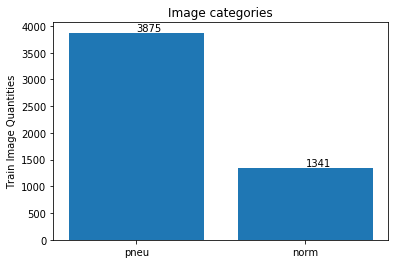

In [3]:


# Load the training files
files_train_sick = glob.glob(PATH_TRAIN_PNEU)
files_train_norm = glob.glob(PATH_TRAIN_NORM)
files_test_sick = glob.glob(PATH_TEST_PNEU)
files_test_norm = glob.glob(PATH_TEST_NORM)
files_validate = glob.glob(PATH_VAL)

# shuffle
random.shuffle(files_train_sick)
random.shuffle(files_train_norm)
random.shuffle(files_test_sick)
random.shuffle(files_test_norm)



print('We have ', len(files_train_sick) ,' pneumonia train files')
print('We have ', len(files_train_norm) ,' normal train files')
print('We have ', len(files_test_sick) ,' pneumonia test files')
print('We have ', len(files_test_norm) ,' normal test files')
print('We have ', len(files_validate) ,' total validation files')



# distrib plot 
x = ('pneu', 'norm')
y = [len(files_train_sick),len(files_train_norm)]
plt.bar(x, height= y)
plt.ylabel('Train Image Quantities')
plt.title('Image categories')
for i, v in enumerate(y):
    plt.text(x[i] , v+30, str(v))
plt.show()

### We make a new training batch with equaly distributed image categories. 
- Similar quantities of each category will make better training.
- TRAIN_SAMPLE_SIZE can at most be twice the val of the cat with the less images : min([len(files_train_sick),len(files_train_norm)])



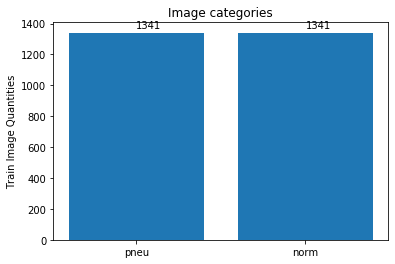

Total images in sample equally distributed dataset :  2682


In [4]:

# We will also make a smaller equally distributed dataset for testing purposes
train_subsample_size = int(TRAIN_SAMPLE_SIZE/2)
files_train_sample = files_train_norm[:train_subsample_size] + files_train_sick[:train_subsample_size]
random.shuffle(files_train_sample)


t = min([len(files_test_sick),len(files_test_norm)])
files_test_final = files_test_norm[:t] + files_test_sick[:t]
random.shuffle(files_test_final)


# distrib plot 
x = ('pneu', 'norm')
y = [len(files_train_sick[:train_subsample_size]),len(files_train_norm[:train_subsample_size])]
plt.bar(x, height= y)
plt.ylabel('Train Image Quantities')
plt.title('Image categories')
for i, v in enumerate(y):
    plt.text(x[i] , v+30, str(v))
plt.show()

print('Total images in sample equally distributed dataset : ', len(files_train_sample))

### Scatter plot for image dimensions distribution will help us see if we need to reshape our images or not.

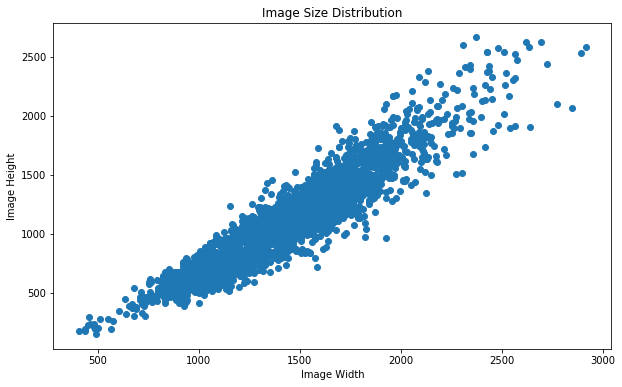

In [14]:
xscatter = []
yscatter = []
for a in files_train_sample:
    img = cv2.imread(a)
    height, width, channels = img.shape
    xscatter.append(height)
    yscatter.append(width)


fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = yscatter, y = xscatter)

plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Image Size Distribution")
plt.show()

### We prepare the data
#### Two options as for image pimping. examples below :
- We either apply CLAHE algorithm on our images in order to enhance contrasts on our images
- Or we apply segmentation to our images in order to enhance contrasts on our image's lungs
#### then we apply the following :
- We label the datasets using one-hot encoding
- We convert the images to RGB (3channels)
- We resize all images to same pixel height and width values
- We normalize the pixel values for better performance while training



 Example of image enhancement with Segmentation 


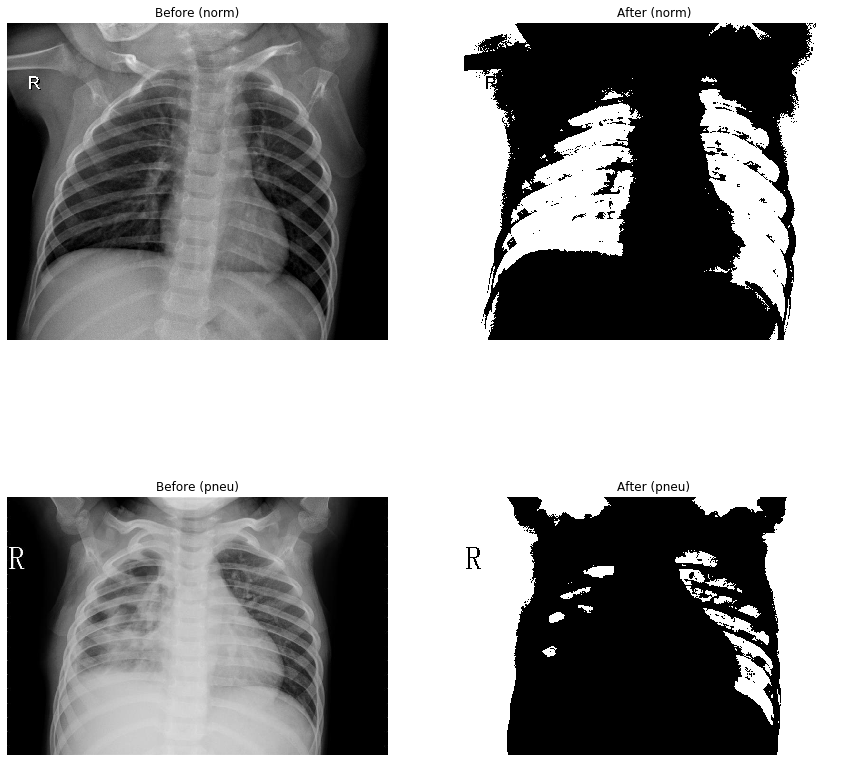

In [15]:
#random image as for example
bgr2 = cv2.imread("/Users/jk/Downloads/chest_Xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg",0)
bgr = cv2.imread("/Users/jk/Downloads/chest_Xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg",0)


ret, cl = cv2.threshold(bgr,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
ret, cl2 = cv2.threshold(bgr2,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
cl = cv2.cvtColor(cl,cv2.COLOR_GRAY2BGR)
cl2 = cv2.cvtColor(cl2,cv2.COLOR_GRAY2BGR)
bgr2 = cv2.cvtColor(bgr2, cv2.COLOR_BGR2RGB)
bgr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)


print(" Example of image enhancement with Segmentation ")


# plotting the results
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.axis('off')
plt.imshow(bgr)
plt.title("Before (norm)")
plt.subplot(222)
plt.axis('off')
plt.imshow(cl)
plt.title("After (norm)")
plt.subplot(223)
plt.axis('off')
plt.imshow(bgr2)
plt.title("Before (pneu)")
plt.subplot(224)
plt.axis('off')
plt.imshow(cl2)
plt.title("After (pneu)")
plt.show()




 Example of image enhancement with CLAHE 


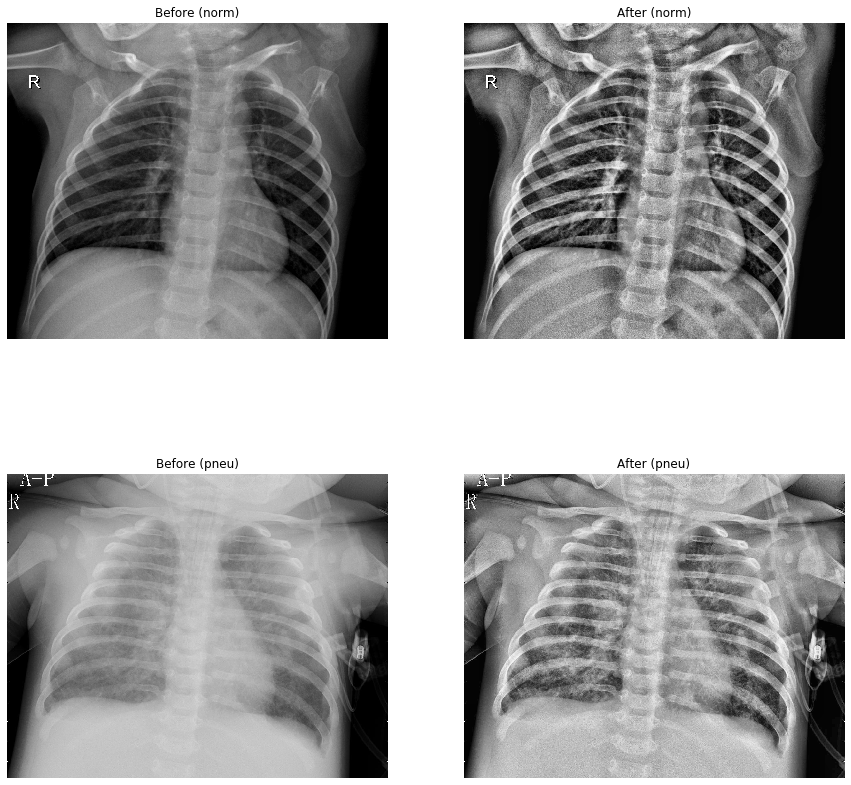

In [16]:
#random image as for example
bgr2 = cv2.imread("/Users/jk/Downloads/chest_Xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg",0)
bgr = cv2.imread("/Users/jk/Downloads/chest_Xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg",0)

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16,16))
cl = clahe.apply(bgr)
cl2 = clahe.apply(bgr2)
cl2 = cv2.cvtColor(cl2, cv2.COLOR_BGR2RGB)
cl = cv2.cvtColor(cl, cv2.COLOR_BGR2RGB)
bgr2 = cv2.cvtColor(bgr2, cv2.COLOR_BGR2RGB)
bgr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)


print(" Example of image enhancement with CLAHE ")


# plotting the results
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.axis('off')
plt.imshow(bgr)
plt.title("Before (norm)")
plt.subplot(222)
plt.axis('off')
plt.imshow(cl)
plt.title("After (norm)")
plt.subplot(223)
plt.axis('off')
plt.imshow(bgr2)
plt.title("Before (pneu)")
plt.subplot(224)
plt.axis('off')
plt.imshow(cl2)
plt.title("After (pneu)")
plt.show()



In [5]:


# label , resize and RGB
def fixData(dataset):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) ### CLAHE
    y_data = []
    x_data = []
    for file in dataset:
        image = cv2.imread(file)
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)  ### SEGMENTATION
        #ret, image = cv2.threshold(image,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) ### SEGMENTATION
        image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY) ### CLAHE
        image = clahe.apply(image) ### CLAHE
        #image = Image.open(file).convert('RGB') ### NORMAL
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        #image = image.resize((IMG_SIZE, IMG_SIZE)) ### NORMAL
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        data = np.array(image)
        x_data.append(data)
        
        # LABELS
        if("virus" in file):
            target = 1
        elif("bacteria" in file):
            target = 1
        else:
            target = 0

        y_data.append(target)    
    x_data = np.asarray(x_data)    
    y_data = np.asarray(y_data)
    y_data = to_categorical(y_data,2)
    return (x_data,y_data)


# Training images
(x_train_sample, y_train_sample) = fixData(files_train_sample)

# Testing images
(x_test, y_test) = fixData(files_test_final)

# Validation images
(x_val, y_val) = fixData(files_validate)


# stats to be printed
print("Features train sample shape : ", x_train_sample.shape)
print("Targets train sample shape  : ", y_train_sample.shape)
print("Features test shape         : ", x_test.shape)
print("Targets test shape          : ", y_test.shape)
print("Features val shape          : ", x_val.shape)
print("Targets val shape           : ", y_val.shape)



# Normalize data
def normData(data):
    xmax = data.max()
    data = data / xmax
    return data


print('Before normalization        : min={}, max={}'.format(x_train_sample.min(), x_train_sample.max()))
x_train_sample = normData(x_train_sample)
x_test = normData(x_test)
print('After normalisation         : min={}, max={}'.format(x_train_sample.min(), x_train_sample.max()))





Features train sample shape :  (2682, 60, 60, 3)
Targets train sample shape  :  (2682, 2)
Features test shape         :  (468, 60, 60, 3)
Targets test shape          :  (468, 2)
Features val shape          :  (16, 60, 60, 3)
Targets val shape           :  (16, 2)
Before normalization       : min=0, max=255
After normalisation        : min=0.0, max=1.0


### Check the Data

#### Here we will display a small sample of our clean dataset


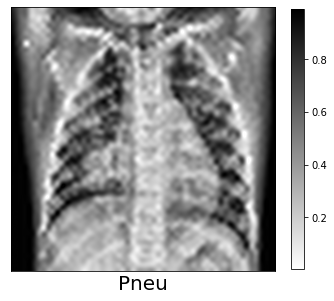

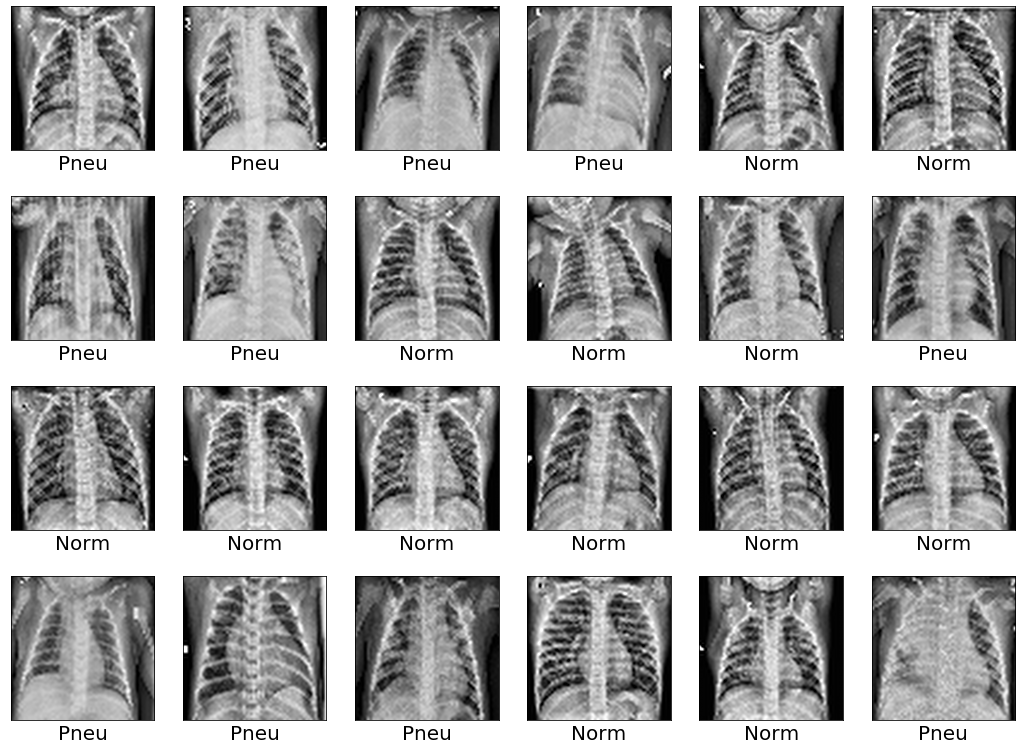

In [6]:


# Targets names for plotting
def targetNames(targets):
    target_names = []
    for target in targets:
        if(target[0] > 0):
            target_names.append("Norm")
        elif(target[1] > 0):
            target_names.append("Pneu")
    return target_names





def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos', save_as='auto'):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns: 
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm, interpolation=interpolation)
        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)
        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i].any()!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    #save_fig(save_as)
    plt.show()


y_names = targetNames(y_train_sample)

plot_images(x_train_sample, y_names, [0], x_size=7, y_size=7, colorbar=True)
plot_images(x_train_sample, y_names, range(0,24),x_size=3, y_size=3, columns=6)

### The Model

#### We will use a convolutional neural network in order to classify our images
#### Specs : 
- 5 convo layers with increasing amount of filters.
- large initial kernell size for catching larger details, then smaller kernells for catching small details
- activation function remains RELU accross the board exept for a final softmax in order to deal with our target probabilities.
- 5 max pooling layers with a grid size of 2x2
- dropouts that will each disactivate 30% of the neurons
- We will use Nadam optimizer in order to benefit of momentum.

In [19]:
"""

### 256x256 segmented images

model = keras.models.Sequential()
model.add(Conv2D(filters=16, kernel_size=(6,6), input_shape=(IMG_SIZE,IMG_SIZE,3), activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=32, kernel_size=(2,2), activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.1))

model.add(Conv2D(filters=64, kernel_size=(2,2), activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.1))
model.add(Conv2D(filters=128, kernel_size=(2,2), activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.1))
model.add(Conv2D(filters=256, kernel_size=(2,2), activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.3))

model.add(Conv2D(filters=512, kernel_size=(2,2), activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))



model.add(Flatten())


model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))




"""


# 60x60 images

model = keras.models.Sequential()
model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=(IMG_SIZE,IMG_SIZE,3), activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(8, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))


#optimizers
#opt = keras.optimizers.Nadam(learning_rate=0.000005, decay = 0.1)
opt2 = keras.optimizers.Adam(learning_rate=0.000005)


model.compile(optimizer=opt2,
              loss='categorical_crossentropy',
             metrics=['accuracy'])


model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 58, 58, 128)       3584      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 29, 29, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 107648)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 861192    
_________________________________________________________________
dense_17 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_18 (Dense)             (None, 32)               

## Train the model

- learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated
- Best learning rate for Adam opti : 3e-4 according to google.

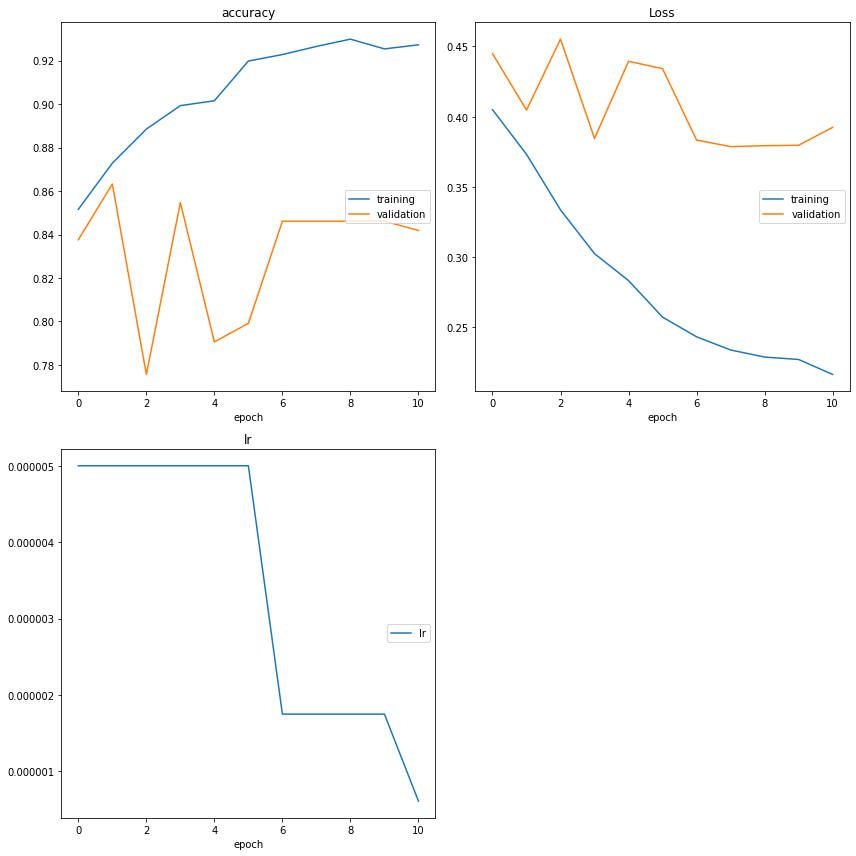

accuracy
	training         	 (min:    0.852, max:    0.930, cur:    0.927)
	validation       	 (min:    0.776, max:    0.863, cur:    0.842)
Loss
	training         	 (min:    0.216, max:    0.405, cur:    0.216)
	validation       	 (min:    0.379, max:    0.455, cur:    0.392)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
Epoch 12/30
119/336 [=========>....................] - ETA: 10s - loss: 0.2304 - accuracy: 0.9254

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=10)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.35, patience=2, verbose=2, mode='auto')



history = model.fit(x_train_sample, y_train_sample,
                   batch_size = 8,
                   epochs = EPOCHS,
                   verbose = 1,
                   validation_data = (x_test, y_test)
                   ,callbacks=[early_stop, lr_reduce, PlotLossesKeras()])
                  # )

In [ ]:


##################################### check 69 -> 1:40 for explanations of these plots

In [39]:
#Évaluation du Modèle
model.metrics_names

print(model.metrics_names)
print(model.evaluate(x_test,y_test,verbose=1))






['loss', 'accuracy']
15/15 [==============================] - 1s 76ms/step - loss: 0.3912 - accuracy: 0.8483
[0.3912059962749481, 0.8482906222343445]


              precision    recall  f1-score   support

           0       0.95      0.74      0.83       234
           1       0.78      0.96      0.86       234

    accuracy                           0.85       468
   macro avg       0.87      0.85      0.85       468
weighted avg       0.87      0.85      0.85       468



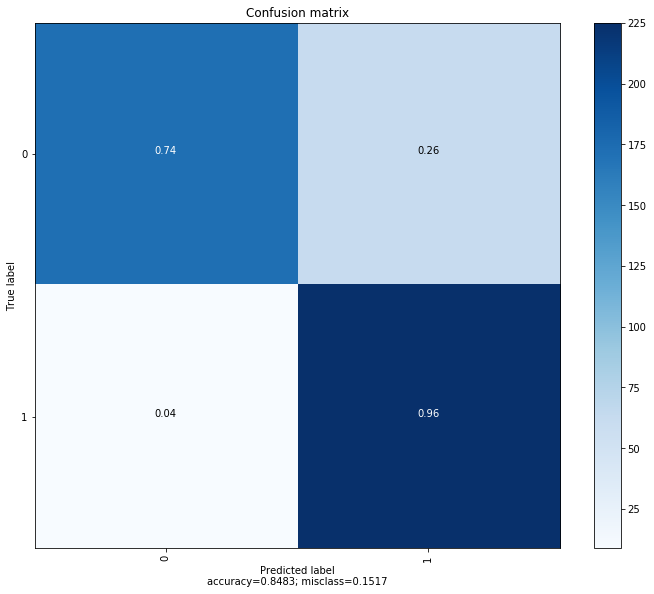

In [40]:
from sklearn.metrics import classification_report,confusion_matrix
import itertools

#put predictions and labels as single digit
predictions = np.argmax(model.predict(x_test), axis=1)
y_test_singleDigit = np.argmax(y_test, axis=1)
y_val_singleDigit = np.argmax(y_val, axis=1)





def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}',
                          save_as='auto'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    cm = confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #save_fig(save_as)
    plt.show()

    
    
    
    
print(classification_report(y_test_singleDigit,predictions))
plot_confusion_matrix(y_test_singleDigit,predictions, range(2), normalize=True)

image single digit label :  1
single digit label predicted by model :  [1]
0 = NORM , 1 = PNEU , pred val ( label val )


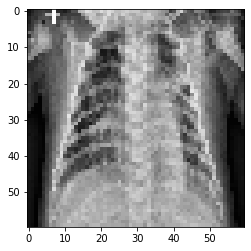

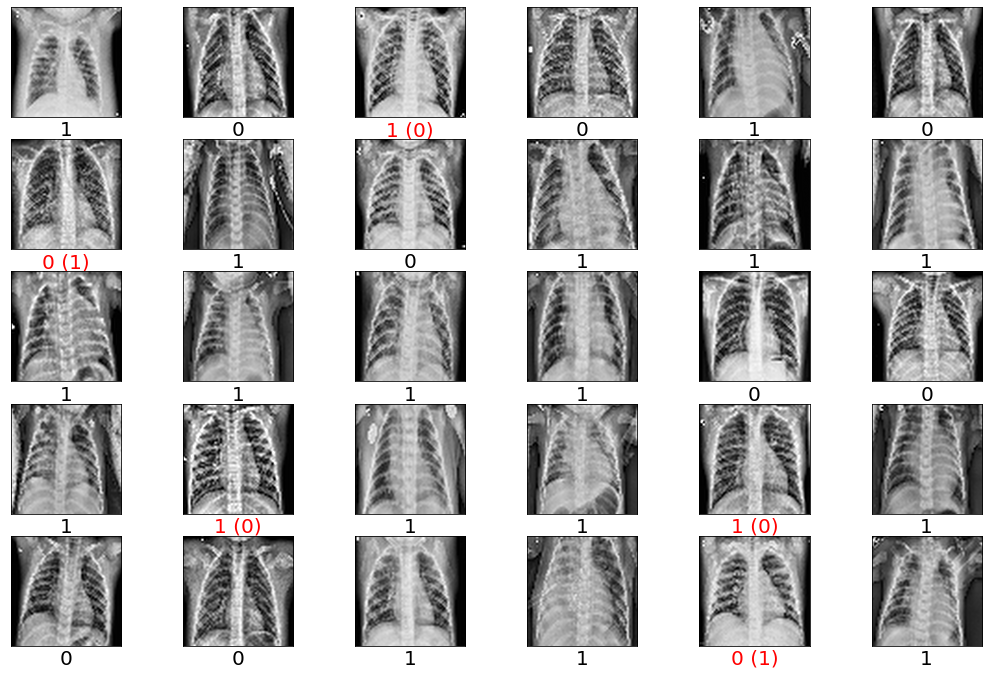

In [41]:
# PLOT SOME RESULTS


my_image = x_val[3]
plt.imshow(my_image)
print('image single digit label : ', y_val_singleDigit[3])
pred = np.argmax(model.predict(my_image.reshape(1,IMG_SIZE,IMG_SIZE,3)), axis=1)
print('single digit label predicted by model : ', pred)


# prediction thumbnails sample
print('0 = NORM , 1 = PNEU , pred val ( label val )') 
y_sigmoid = model.predict(x_test)
y_pred = np.argmax(y_sigmoid, axis=-1)
plot_images(x_test, y_test_singleDigit, range(0,30), columns=6, x_size=3, y_size=2, y_pred=y_pred)

0 = NORM , 1 = PNEU , predicted val ( labeled val )


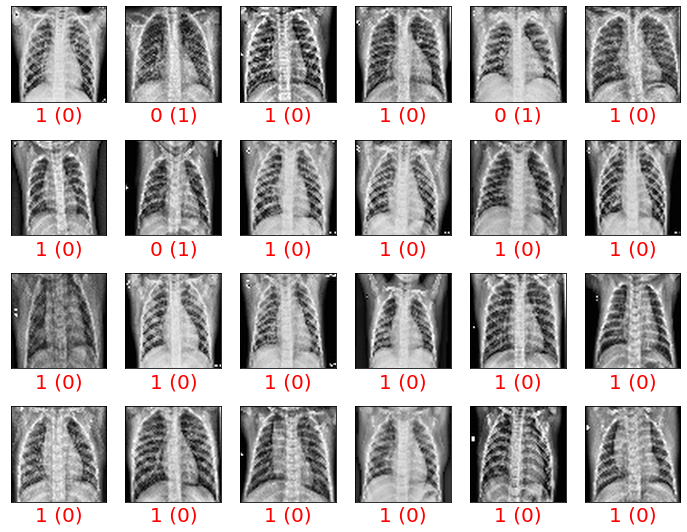

In [42]:
# PLOT SOME ERRORS

print('0 = NORM , 1 = PNEU , predicted val ( labeled val )') 
errors=[ i for i in range(len(x_test)) 
        if y_pred[i]!=y_test_singleDigit[i]]
errors=errors[:min(24, len(errors))]
plot_images(x_test, y_test_singleDigit, errors[:55], 
            columns=6, x_size=2, y_size=2, y_pred=y_pred)

In [ ]:
# show original img next to errors  ^
# same and load trained model
# 

"""
KICKOFF =>

MAKE A ROC AUC CURVE IF 2 TARGETS
https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/



useatrain-validation-testprocedure,
• useacrossvalidationprocedure,
• compareyourresultswithasimpletraintestsplit,



Do not let your algorithm(s) make bad habits.
Find the correct balance between bias and variance.
Cross validation procedures can help you solve this problem.
It’s also a good idea when you don’t have a lot of data.
Algorithms’ parameters can also help you to find a trade-off between bias and variance, this is why you need a good understanding on how they work.




SEABORN
"""